In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

import string

from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import json
import collections
import operator
import random
import seaborn as sns
from sklearn.model_selection import train_test_split


import tensorflow_hub as hub
import tensorflow_text as text

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
train_file = pd.read_csv('clean.csv')

In [3]:
train_file.columns, train_file.shape

(Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
        'identity_hate', 'label'],
       dtype='object'),
 (159513, 8))

In [4]:
max_label_length = 6
new_label = []
for each in train_file['label']:
    temp = str(each)
    if len(temp) != max_label_length:
        zeros = max_label_length - len(str(each))
        res = temp.rjust(zeros + len(temp), '0')
        new_label.append(res)
    else:
        new_label.append(temp)    

In [5]:
train_file['label'] = new_label

## Binary classification

In [6]:
train_file = train_file.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis = 1)

In [7]:
all_toxic = train_file[(train_file.label != '000000')].reset_index(drop = True)
non_toxic = train_file[(train_file.label == '000000')].reset_index(drop = True)

In [8]:
all_toxic.shape, non_toxic.shape

((16225, 2), (143288, 2))

In [9]:
del train_file

In [10]:
non_toxic_labels = [0] * non_toxic.shape[0]
toxic_labels = [1] * all_toxic.shape[0]

In [11]:
non_toxic['label'] = non_toxic_labels
all_toxic['label'] = toxic_labels

In [12]:
non_toxic.head(4), all_toxic.head(4)

(                                        comment_text  label
 0  explanation edits made username hardcore metal...      0
 1  aww matches background colour seemingly stuck ...      0
 2  hey man really trying edit war guy constantly ...      0
 3  make real suggestions improvement wondered sec...      0,
                                         comment_text  label
 0                        cocksucker piss around work      1
 1  hey talk exclusive group wp talibans good dest...      1
 2            bye look come think comming back tosser      1
 3  gay antisemmitian archangel white tiger meow g...      1)

In [13]:
whole_frame = pd.concat([non_toxic, all_toxic], ignore_index=True)

In [14]:
train, non_train = train_test_split(whole_frame, test_size=0.1, random_state=42, stratify = whole_frame['label'], shuffle = True)
val, test = train_test_split(non_train, test_size=0.1, random_state=42, stratify = non_train['label'], shuffle = True)
train.shape, val.shape, test.shape

((143561, 2), (14356, 2), (1596, 2))

In [15]:
del non_toxic
del all_toxic

x_train = train['comment_text']
y_train = train['label']

x_val = val['comment_text']
y_val = val['label']

x_test = test['comment_text']
y_test = test['label']


del train
del val
del test

In [16]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

#### One is to perform preprocessing (tfhub_handle_preprocess) and the other one for encoding (tfhub_handle_encoder).
#### We are not training the BERT model hence the trainability is kept False. We are joining a dropout and dense layer (with number of outputs) to the output of the BERT model. 

In [17]:
#one to perform preprocessing and the other one for encoding.

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [18]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [19]:
classifier_model = build_classifier_model()

Metal device set to: Apple M2 Max


2023-04-25 13:58:06.153819: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [20]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.8),
      #tf.keras.metrics.Precision(name='precision', thresholds=0.8),
      #tf.keras.metrics.Recall(name='recall', thresholds=0.8)
]

classifier_model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [22]:
epochs = 2

In [23]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x = x_train, y = y_train,
                               validation_data=(x_val, y_val),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/2
4487/4487 [==============================] - 771s 171ms/step - loss: 0.2614 - accuracy: 0.8992 - val_loss: 0.2252 - val_accuracy: 0.9023
Epoch 2/2
4487/4487 [==============================] - 1128s 252ms/step - loss: 0.2218 - accuracy: 0.9061 - val_loss: 0.2135 - val_accuracy: 0.9099


In [29]:

y_predicted = classifier_model.predict(x_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.8, 1, 0)
y_predicted


print(accuracy_score(y_test, y_predicted))
print(precision_score(y_test, y_predicted, average='weighted'))
print(recall_score(y_test, y_predicted, average='weighted'))
print(f1_score(y_test, y_predicted, average='micro'))
print(confusion_matrix(y_test, y_predicted))

0.9122807017543859
0.9200829265030429
0.9122807017543859
0.9122807017543859
[[1434    0]
 [ 140   22]]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


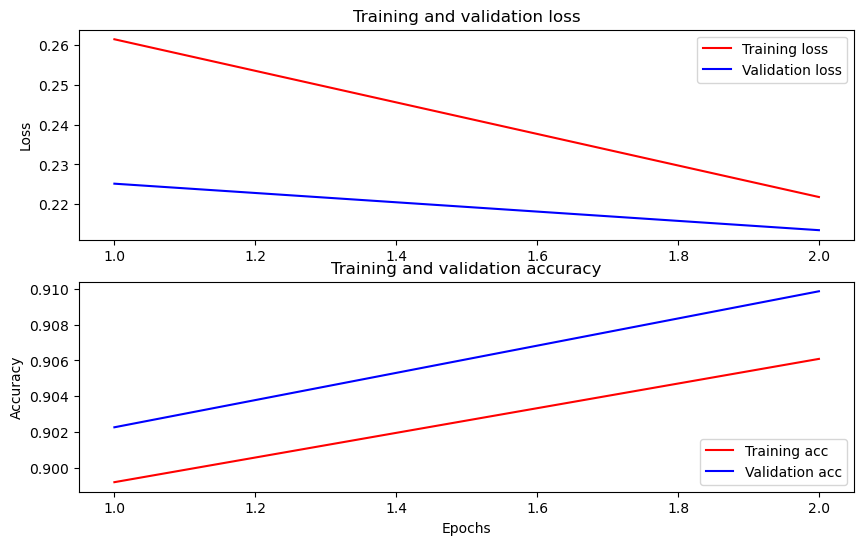

In [30]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')